In [5]:
import json, os, re
from metadata_metrics import readability_score, completeness_score_img, completeness_score_jsonxml, completeness_score_keyword, completeness_score_netcdf, completeness_score_tabular, tfidf_score
import numpy as np
import matplotlib.pyplot as plt

In [6]:

def get_metadata_metrics(dequeue_list, file_to_index_dict):
	readability_scores = dict()
	completeness_scores = dict()
	tfidf_scores = dict()
	count = 0
	for key, value in dequeue_list.items():
		parsed_key = key.split("/")
		filename = parsed_key[len(parsed_key) - 1]
		if value == 1: # keyword
			filepath = '/home/cc/CDIACMetadataExtract/CDIACKeywordExtract/' + filename + 'KWXtract' + file_to_index_dict[key] + '.json'
			completeness_scores[key] = completeness_score_keyword(filepath)
		elif value == 2: # tabular
			filepath = '/home/cc/CDIACMetadataExtract/CDIACTabularExtracted/' + filename +  'TabXtract' + file_to_index_dict[key] + '.json'
			completeness_scores[key] = completeness_score_tabular(filepath)
		#elif value == 3: # unknown
		#	filepath = '/home/cc/CDIACMetadataExtract/CDIACKeywordExtract/' + key + file_to_index_dict[key] + 'KWXtract.json'
		elif value == 4: #json/xml
			filepath = '/home/cc/CDIACMetadataExtract/CDIACJSONXMLExtracted/' + filename + 'JSONXMLXtract' + file_to_index_dict[key] + '.json'
			completeness_scores[key] = completeness_score_jsonxml(filepath)
		elif value == 5: #netcdf
			filepath = '/home/cc/CDIACMetadataExtract/CDIACNETCDFExtracted/' + filename + 'NetCDFXtract' + file_to_index_dict[key] + '.json'
			completeness_scores[key] = completeness_score_netcdf(filepath)
		elif value == 6:
			filepath = '/home/cc/CDIACMetadataExtract/CDIACImgPredictions/' + filename + 'ImgXtract' + file_to_index_dict[key] + '.json'
			completeness_scores[key] = completeness_score_img(filepath)

		readability_scores[key] = readability_score(filepath)
		tfidf_scores[key] = tfidf_score(filepath)
	
	return readability_scores, completeness_scores, tfidf_scores

# IGNORE

## Readability

In [ ]:
with open("Queues/dequeue_list_FIRST_ONE.json", "r") as fp:
	dequeue_list = json.load(fp)
with open("EstimateTime/file_to_index.json", "r") as fp:
	file_to_index_dict = json.load(fp)
file_to_index_dict = dict(zip(file_to_index_dict.values(), file_to_index_dict.keys()))

readability_scores, completeness_scores, tfidf_scores = get_metadata_metrics(dequeue_list, file_to_index_dict)

In [ ]:
valid = 0
readable = []
for key, value in readability_scores.items():
	if value != 'no strings':
		valid += 1
		readable.append(value)

print(len(readable))
avg_readability = sum(readable) / len(readable)
print(avg_readability)

## Completeness

In [ ]:
complete = 0
complete_valid = []

for key, value in completeness_scores.items():
	complete += 1

	if complete > 0:
		complete_valid.append(value)


print(len(complete_valid))

avg_completeness = sum(complete_valid) / len(complete_valid)
print(avg_readability)

# TFIDF

In [ ]:
nonzero = 0
tfidf_valid = []

for key, value in tfidf_scores.items():
	if value > 0:
		nonzero += 1
		tfidf_valid.append(value)
print(len(tfidf_valid))

avg_tfidf = sum(tfidf_valid) / len(tfidf_valid)
print(avg_tfidf)
			

# Experimentation

In [7]:
with open("EstimateTime/file_to_index.json", "r") as fp:
	file_to_index_dict = json.load(fp)
file_to_index_dict = dict(zip(file_to_index_dict.values(), file_to_index_dict.keys()))

Threshold:  0.1
Readability:  75.87500000000001
Completeness 0.31343465610463117
TFIDF 0.5
Threshold:  0.2
Readability:  75.87500000000001
Completeness 0.3103280620936022
TFIDF 0.5
Threshold:  0.3
Readability:  75.87500000000001
Completeness 0.3212118860040707
TFIDF 0.5
Threshold:  0.4
Readability:  75.87500000000001
Completeness 0.35346529998120335
TFIDF 0.5
Threshold:  0.5
Readability:  75.87500000000001
Completeness 0.3550141251884534
TFIDF 0.5
Threshold:  0.6
Readability:  75.87500000000001
Completeness 0.3483787378416416
TFIDF 0.5
Threshold:  0.7
Readability:  67.35395833333332
Completeness 0.3290849503199412
TFIDF 0.4145728111794096
Threshold:  0.8
Readability:  65.2513636363636
Completeness 0.32452023238748884
TFIDF 0.39349337497692616
Threshold:  0.9
Readability:  67.18005952380949
Completeness 0.32140238842186003
TFIDF 0.41282939916266254
Threshold:  1
Readability:  66.00506756756754
Completeness 0.3218329246291733
TFIDF 0.4010495882386982


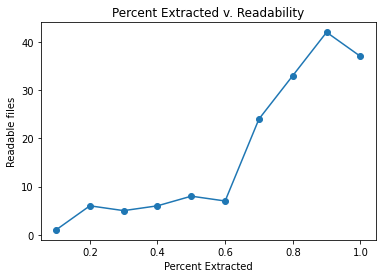

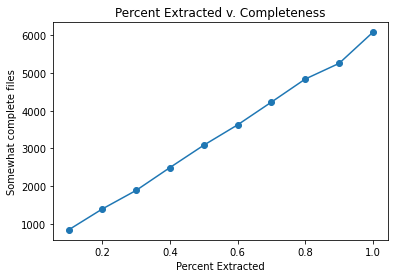

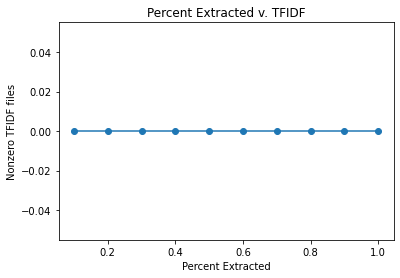

In [9]:
X = []
Y_readability = []
Y_completeness = []
Y_tfidf = []

readability_total = dict()
completeness_total = dict()
tfidf_total = dict()

average_readability = []
average_completeness = []
average_tfidf = []

for subdir, dirs, files in os.walk("Experiment2/"):
	for file in sorted(files):
		filepath = os.path.join(subdir, file)
		threshold = re.search("dequeue_list_threshold_(.*).json", file).group(1)
		print("Threshold: ", threshold)
		X.append(float(threshold))
		with open(filepath, "r") as fp:
			dequeue_list = json.load(fp)
		readability_scores, completeness_scores, tfidf_scores = get_metadata_metrics(dequeue_list, file_to_index_dict)

		readable_count = 0
		readable = []
		for key, value in readability_scores.items():
			if value != 'no strings':
				readable_count += 1
				readable.append(value)

		#plt.boxplot(readable)
		#plt.show()
		Y_readability.append(float(readable_count))
		readability_total[threshold] = readable

		#print(len(readable))
		avg_readability = sum(readable) / len(readable)
		print("Readability: ", avg_readability)
		average_readability.append(avg_readability)

		complete = 0
		complete_valid = []

		for key, value in completeness_scores.items():
			if value > 0:
				complete += 1
				complete_valid.append(value)
		
		#plt.boxplot(complete_valid)
		#plt.show()
		Y_completeness.append(float(complete))
		completeness_total[threshold] = complete_valid

		#print(len(complete_valid))
		avg_completeness = sum(complete_valid) / len(complete_valid)
		print("Completeness", avg_completeness)
		average_completeness.append(avg_completeness)

		nonzero_tfidf = 0
		tfidf_valid = []
		
		for key, value in tfidf_scores.items():
			if value > 0:
				nonzero_tfidf = 0
				tfidf_valid.append(value)
		Y_tfidf.append(float(nonzero_tfidf))
		tfidf_total[threshold] = tfidf_valid

		#print(len(complete_valid))
		avg_tfidf = sum(tfidf_valid) / len(tfidf_valid)
		print("TFIDF", avg_tfidf)
		average_tfidf.append(avg_tfidf)


X = np.asarray(X)
Y_readability = np.asarray(Y_readability)
Y_completeness = np.asarray(Y_completeness)

plt.title("Percent Extracted v. Readability")
plt.xlabel("Percent Extracted")
plt.ylabel("Readable files")
plt.scatter(X, Y_readability)
plt.plot(X, Y_readability)
plt.show()

plt.title("Percent Extracted v. Completeness")
plt.xlabel("Percent Extracted")
plt.ylabel("Somewhat complete files")
plt.scatter(X, Y_completeness)
plt.plot(X, Y_completeness)
plt.show()

plt.title("Percent Extracted v. TFIDF")
plt.xlabel("Percent Extracted")
plt.ylabel("Nonzero TFIDF files")
plt.scatter(X, Y_tfidf)
plt.plot(X, Y_tfidf)
plt.show()

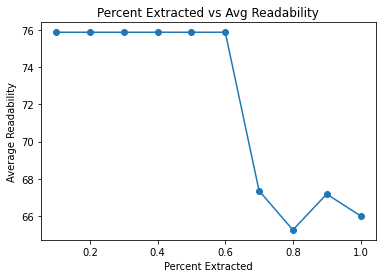

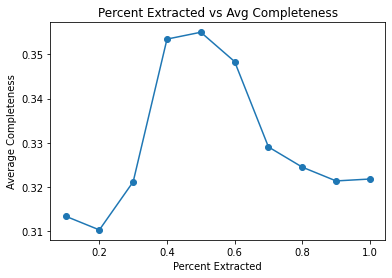

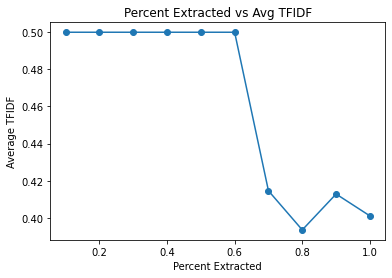

In [11]:
plt.scatter(X, average_readability)
plt.plot(X, average_readability)
plt.xlabel("Percent Extracted")
plt.ylabel("Average Readability")
plt.title("Percent Extracted vs Avg Readability")
plt.show()

plt.scatter(X, average_completeness)
plt.plot(X, average_completeness)
plt.xlabel("Percent Extracted")
plt.ylabel("Average Completeness")
plt.title("Percent Extracted vs Avg Completeness")
plt.show()

plt.scatter(X, average_tfidf)
plt.plot(X, average_tfidf)
plt.xlabel("Percent Extracted")
plt.ylabel("Average TFIDF")
plt.title("Percent Extracted vs Avg TFIDF")
plt.show()

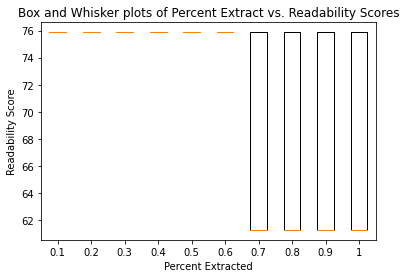

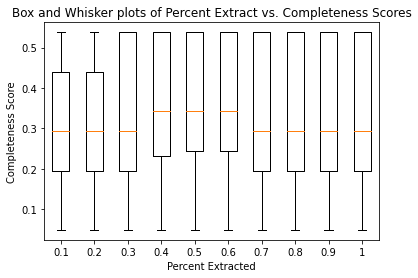

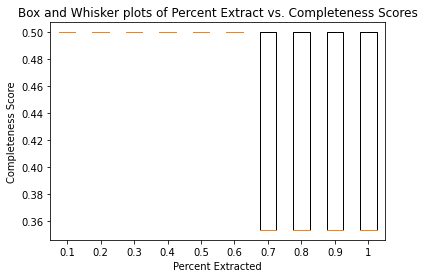

In [12]:
labels, data = [*zip(*readability_total.items())]  # 'transpose' items to parallel key, value lists
#for d in data:
	#print(d)
plt.boxplot(data, meanline=True)
plt.xticks(range(1, len(labels) + 1), labels)
plt.title("Box and Whisker plots of Percent Extract vs. Readability Scores")
plt.xlabel("Percent Extracted")
plt.ylabel("Readability Score")
plt.show()

labels, data = [*zip(*completeness_total.items())]  # 'transpose' items to parallel key, value lists
plt.boxplot(data)
plt.xticks(range(1, len(labels) + 1), labels)
plt.xlabel("Percent Extracted")
plt.ylabel("Completeness Score")
plt.title("Box and Whisker plots of Percent Extract vs. Completeness Scores")
plt.show()

labels, data = [*zip(*tfidf_total.items())]  # 'transpose' items to parallel key, value lists
plt.boxplot(data)
plt.xticks(range(1, len(labels) + 1), labels)
plt.xlabel("Percent Extracted")
plt.ylabel("Completeness Score")
plt.title("Box and Whisker plots of Percent Extract vs. Completeness Scores")
plt.show()

